# xgboost model verification

# Feature Engineering

In [1]:
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error,r2_score
import time
%matplotlib inline

import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
Contributions from:
DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503
hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

Also all comments for changes, encouragement, and forked scripts rock

Keep the Surprise Going
"""

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime

data = {
    'tra': pd.read_csv('../../../mltestdata/05_recruit/air_visit_data.csv'),
    'as': pd.read_csv('../../../mltestdata/05_recruit/air_store_info.csv'),
    'hs': pd.read_csv('../../../mltestdata/05_recruit/hpg_store_info.csv'),
    'ar': pd.read_csv('../../../mltestdata/05_recruit/air_reserve.csv'),
    'hr': pd.read_csv('../../../mltestdata/05_recruit/hpg_reserve.csv'),
    'id': pd.read_csv('../../../mltestdata/05_recruit/store_id_relation.csv'),
    'tes': pd.read_csv('../../../mltestdata/05_recruit/sample_submission.csv'),
    'hol': pd.read_csv('../../../mltestdata/05_recruit/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [3]:
for c, dtype in zip(train.columns, train.dtypes):	
    if dtype == np.float64:		
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):	
    if dtype == np.float64:		
        test[c] = test[c].astype(np.float32)

In [4]:
drop_cols=['visitors','air_store_id','visit_date','id']
y_train=train['visitors']
x_train=train.drop(drop_cols, axis=1)

x_test=test.copy()
x_test=x_test.drop(drop_cols, axis=1)

In [5]:
y = train.visitors
train_input = train.copy()
test_input = test.copy()

drop_cols=['visitors','air_store_id','visit_date','id']
train_input=train_input.drop(drop_cols, axis=1)
test_input=test_input.drop(drop_cols, axis=1)

# Modeling

## xgboost

In [6]:
#Define a evaluation function

def rmsle(preds, true):
    rmsle = np.sqrt(mean_squared_error(np.log1p(true), np.log1p(preds)))
    return float(rmsle)

In [7]:
#Define a evaluation matrix 
from sklearn.metrics.scorer import make_scorer
RMSLE = make_scorer(rmsle)

In [8]:
# Define a function for comparing predictions and true data.
def compare_result(preds, true):
    compare = pd.DataFrame({"test_id": true.index,
                           "real_cost": true,
                           "pred_cost": preds})
    compare = compare[["test_id", "real_cost", "pred_cost"]].reset_index(drop=True)
    
    compare["error_percent_(%)"] = np.abs(compare.real_cost - compare.pred_cost) / compare.real_cost * 100
    
    return compare

# Cross validation with xgboost

In [23]:
def cross_validate_xgb(params, x_train, y_train, x_test, kf,  verbose=True, verbose_eval=50, bopt=False):
    start_time=time.time()
    nround=[]
    # the prediction matrix need to contains 3 columns, one for the probability of each class
    #train_pred = np.zeros((x_train.shape[0],3))
    train_pred = np.zeros((x_train.shape[0]))
    test_pred = np.zeros((x_test.shape[0]))
    
    # self-defined eval metric
    # f(preds: array, train_data: Dataset) -> name: string, value: array, is_higher_better: bool
    # binary error
    def feval_rmsle(preds, train_data):
        preds = np.expm1(preds)
        true = np.expm1(train_data.get_label())
        #return 'rmsle', rmsle(true, preds), False

        return 'rmsle', rmsle(preds, true), False

    # use the k-fold object to enumerate indexes for each training and validation fold
    for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
        x_train_kf, x_val_kf = x_train.loc[train_index, :], x_train.loc[val_index, :]

        #y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        y_train_kf, y_val_kf = np.log1p(y_train[train_index]), np.log1p(y_train[val_index])
        x_test_kf=x_test.copy()
        
        d_train = xgboost.DMatrix(x_train_kf, y_train_kf)
        d_val=xgboost.DMatrix(x_val_kf, y_val_kf)
        d_test = xgboost.DMatrix(x_test_kf)
        
        watchlist= [(d_train, "train"), (d_val, 'val')]
        bst = xgboost.train(params=params, 
                            dtrain=d_train, 
                            num_boost_round=8000, 
                            early_stopping_rounds=100,
                            evals=watchlist, 
                            verbose_eval=verbose_eval)        
        
        y_val_kf_preds=bst.predict(d_val, ntree_limit=bst.best_ntree_limit)
        nround.append(bst.best_ntree_limit)
        
        train_pred[val_index] += y_val_kf_preds
#        test_pred += np.expm1((bst.predict(x_test, ntree_limit=bst.best_ntree_limit)))
        test_pred += np.expm1(bst.predict(d_test))
        
        
        #fold_cv = log_loss(y_val_kf.values, y_val_kf_preds)
        fold_rmsle = rmsle(np.expm1(train_pred[val_index]),np.expm1(y_val_kf.values))
        fold_cv = fold_rmsle
        
        if verbose:
            print('fold cv {} rmsle score is {:.6f}'.format(i, fold_cv))

    test_pred = test_pred / kf.n_splits
    #cv_score = log_loss(y_train, train_pred)
    cv_score = rmsle(np.expm1(train_pred), y_train)
    
    if verbose:
        print('cv rmsle score is {:.6f}'.format(cv_score))    
        end_time = time.time()
        print("it takes %.3f seconds to perform cross validation" % (end_time - start_time))
 
    if bopt:
        #return cv_score # for the purpose of bayesian optimisation, we only need to return the CV score
        return cv_score
    else:
        return (cv_score,train_pred,test_pred)

In [10]:
xgb_params = {
    "objective" : "reg:gamma",
    #"num_class" : 3,
    #"tree_method" : "hist",
    "eval_metric" : "rmse",
    "nthread": 4,
    "seed" : 0,
    'silent': 1,

    "eta":0.05,  # default 0.3
    "max_depth" : 5, # default 6
    "subsample" : 0.8, # default 1
    "colsample_bytree" : 0.6, # default 1
    "gamma": 0.5
}

# only do 3 fold CV here so that we save some running time on Kaggle Kernel
kf=StratifiedKFold(n_splits=3, shuffle=True, random_state=2018)

print('Start training...')

cv_score =cross_validate_xgb(xgb_params, train_input, y, test_input, kf, verbose=False, verbose_eval=50)

print('cv score is {:.6f}'.format(cv_score))

Start training...
[0]	train-rmse:2.42034	val-rmse:2.42085
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[50]	train-rmse:0.960719	val-rmse:0.959755
[100]	train-rmse:0.515669	val-rmse:0.516404
[150]	train-rmse:0.502155	val-rmse:0.504174
[200]	train-rmse:0.499474	val-rmse:0.502189
[250]	train-rmse:0.497879	val-rmse:0.501087
[300]	train-rmse:0.496597	val-rmse:0.500331
[350]	train-rmse:0.495482	val-rmse:0.499779
[400]	train-rmse:0.494744	val-rmse:0.499463
[450]	train-rmse:0.494101	val-rmse:0.499145
[500]	train-rmse:0.493631	val-rmse:0.498944
[550]	train-rmse:0.493063	val-rmse:0.498708
[600]	train-rmse:0.492522	val-rmse:0.498401
[650]	train-rmse:0.492008	val-rmse:0.498154
[700]	train-rmse:0.491527	val-rmse:0.497933
[750]	train-rmse:0.491144	val-rmse:0.497797
[800]	train-rmse:0.490653	val-rmse:0.497633
[850]	train-rmse:0.490148	val-rmse:0.497403
[900]	train-rmse:0.489639	val-rmse:0.497157
[950]	tra

TypeError: unsupported format string passed to tuple.__format__

# Bayesian Optimsation - Setup

In [11]:
params={'max_depth':(4,10),
        'learning_rate':(0.05,0.3),
        'subsample': (0.4, 1),
        'colsample_bytree': (0.4, 1),
        'gamma': (0.001, 10.0),
        'min_child_weight': (0, 20),
        'max_delta_step': (0, 10),
        'n_estimators': (10, 25),
        'min_samples_split': (2, 20),
        'max_features': (0.1, 0.999)
       }

In [12]:
# reload(xgb_wrapper)
def xgbcv_func(max_depth, learning_rate, subsample, 
               colsample_bytree, gamma, min_child_weight, 
               max_delta_step, n_estimators, 
               min_samples_split, max_features,nthread=4, seed=0):
    params = {
        "objective" : "reg:gamma",
        #"num_class" : 3,
        #"tree_method" : "hist",
        "eval_metric" : "rmse",
        "nthread": nthread,
        "seed" : 0,
        'silent': 1,

        "eta":learning_rate,  # default 0.3
        "max_depth" : int(max_depth), # default 6
        "subsample" : subsample, # default 1
        "colsample_bytree" : colsample_bytree, # default 1

        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'max_delta_step': max_delta_step,
        'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'max_features': max_features    

    }
    
    # for a more ideal out-of-fold model prediction for this dataset, we use 10-fold CV
    kf=StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
    
    # we will disable all the verbose setting in this functional call, so that we don't have too much information 
    # to read during the bayesian optimisation process.
    return 1-cross_validate_xgb(params, train_input, y, test_input, kf, verbose=False, verbose_eval=False, bopt=True)

In [13]:
xgb_bo=BayesianOptimization(xgbcv_func, params)

In [51]:
xgb_bo.maximize(init_points=5, n_iter=20)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_delta_step |   max_depth |   max_features |   min_child_weight |   min_samples_split |   n_estimators |   subsample | 
    1 | 10m41s |    0.45836 |             0.5555 |    1.8385 |          0.2968 |           8.3539 |      9.6366 |         0.6203 |             8.1246 |             16.2850 |        14.1175 |      0.7658 | 
    2 | 09m19s |    0.44991 |             0.7662 |    0.6880 |          0.2618 |           2.6014 |      4.1387 |         0.9834 |             9.6639 |             12.6731 |        22.7566 |      0.5045 | 
    3 | 06m08s |    0.37998 |             0.4164 |    6.1556 |          0.1714 |           4.7143 |      5.6440 |         0.6810 |            16.9708 |           

In [62]:
xgb_bo.res['max']['max_params']

{'colsample_bytree': 1.0,
 'gamma': 0.001,
 'learning_rate': 0.05000000200182169,
 'max_delta_step': 0.0,
 'max_depth': 10.0,
 'max_features': 0.10000000000000001,
 'min_child_weight': 20.0,
 'min_samples_split': 20.0,
 'n_estimators': 25.0,
 'subsample': 1.0}

In [63]:
print('-'*30)
print('Final Results')
print('Maximum value: %f' % xgb_bo.res['max']['max_val'])
print('Best parameters: ', xgb_bo.res['max']['max_params'])

------------------------------
Final Results
Maximum value: 0.486679
Best parameters:  {'max_depth': 10.0, 'learning_rate': 0.05000000200182169, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.001, 'min_child_weight': 20.0, 'max_delta_step': 0.0, 'n_estimators': 25.0, 'min_samples_split': 20.0, 'max_features': 0.10000000000000001}


# Velification

In [ ]:
Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_delta_step |   max_depth |   max_features |   min_child_weight |   min_samples_split |   n_estimators |   subsample | 
   1 | 10m41s |    0.45836 |             0.5555 |    1.8385 |          0.2968 |           8.3539 |      9.6366 |         0.6203 |             8.1246 |             16.2850 |        14.1175 |      0.7658 | 
    2

In [135]:
train_input.shape

(252108, 50)

In [136]:
test_input.shape

(32019, 50)

In [134]:
train_input.columns

Index(['dow', 'year', 'month', 'day_of_week', 'holiday_flg', 'min_visitors',
       'mean_visitors', 'median_visitors', 'max_visitors',
       'count_observations', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1',
       'air_area_name1', 'air_genre_name2', 'air_area_name2',
       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
       'air_area_name4', 'air_genre_name5', 'air_area_name5',
       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
       'air_area_name7', 'air_genre_name8', 'air_area_name8',
       'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x',
       'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'total_reserv_sum',
       'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int',
       'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2'],
      dtype='object')

In [137]:
test_input.columns

Index(['dow', 'year', 'month', 'day_of_week', 'holiday_flg', 'min_visitors',
       'mean_visitors', 'median_visitors', 'max_visitors',
       'count_observations', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1',
       'air_area_name1', 'air_genre_name2', 'air_area_name2',
       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
       'air_area_name4', 'air_genre_name5', 'air_area_name5',
       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
       'air_area_name7', 'air_genre_name8', 'air_area_name8',
       'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x',
       'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'total_reserv_sum',
       'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int',
       'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2'],
      dtype='object')

In [14]:
xgb_params = {
    "objective" : "reg:gamma",
    "eval_metric" : "rmse",
    "nthread": 4,
    "seed" : 0,
    'silent': 1,
    "colsample_bytree"  :  0.5555, 
    "gamma": 1.8385,
    "learning_rate": 0.2968,
    "max_delta_step": 8.3539,
    "max_depth": 10,#9.6366,
    "max_features": 0.6203,
    "min_child_weight": 8.1246,
    "min_samples_split": 16.2850,
    "n_estimators": 14.1175,
    "subsample": 0.7658,
    "seed": 0,
    'silent': 1
}

outcomes=cross_validate_xgb(xgb_params, train_input, y, test_input, kf, verbose_eval=False)

xgb_cv=outcomes[0]
xgb_train_pred=outcomes[1]
xgb_test_pred=outcomes[2]

xgb_train_pred_df=pd.DataFrame(columns=['visitors'], data=xgb_train_pred)
xgb_test_pred_df=pd.DataFrame(columns=['visitors'], data=xgb_test_pred)
print("Done")

fold cv 0 rmsle score is 0.497094
fold cv 1 rmsle score is 0.501248
fold cv 2 rmsle score is 0.496586
cv rmsle score is 0.498314
it takes 307.088 seconds to perform cross validation
Done


In [17]:
xgb_params = {
    "objective" : "reg:gamma",
    "eval_metric" : "rmse",
    "nthread": 4,
    "seed" : 0,
    'silent': 1,
    'max_depth': 10, 
    'learning_rate': 0.05000000200182169, 
    'subsample': 1.0, 
    'colsample_bytree': 1.0, 
    'gamma': 0.001, 
    'min_child_weight': 20.0, 
    'max_delta_step': 0.0, 
    'n_estimators': 25.0, 
    'min_samples_split': 20.0, 
    'max_features': 0.10000000000000001
}

outcomes=cross_validate_xgb(xgb_params, x_train, y_train, test_input, kf, verbose_eval=False)

xgb_cv=outcomes[0]
xgb_train_pred=outcomes[1]
xgb_test_pred=outcomes[2]

xgb_train_pred_df=pd.DataFrame(columns=['visitors'], data=xgb_train_pred)
xgb_test_pred_df=pd.DataFrame(columns=['visitors'], data=xgb_test_pred)
print("Done")

fold cv 0 rmsle score is 0.491962
fold cv 1 rmsle score is 0.496301
fold cv 2 rmsle score is 0.490484
cv rmsle score is 0.492923
it takes 161.602 seconds to perform cross validation
Done


In [24]:
xgb_params = {
    "objective" : "reg:gamma",
    "eval_metric" : "rmse",
    "nthread": 4,
    "seed" : 0,
    'silent': 1,
    'max_depth': 10, 
    'learning_rate': 0.05000000200182169, 
    'subsample': 1.0, 
    'colsample_bytree': 1.0, 
    'gamma': 0.001, 
    'min_child_weight': 20.0, 
    'max_delta_step': 0.0, 
    'n_estimators': 25.0, 
    'min_samples_split': 20.0, 
    'max_features': 0.10000000000000001
}

outcomes=cross_validate_xgb(xgb_params, x_train, y_train, test_input, kf, verbose_eval=False)

xgb_cv=outcomes[0]
xgb_train_pred=outcomes[1]
xgb_test_pred=outcomes[2]

xgb_train_pred_df=pd.DataFrame(columns=['visitors'], data=xgb_train_pred)
xgb_test_pred_df=pd.DataFrame(columns=['visitors'], data=xgb_test_pred)
print("Done")

fold cv 0 rmsle score is 0.491962
fold cv 1 rmsle score is 0.496301
fold cv 2 rmsle score is 0.490484
cv rmsle score is 0.492923
it takes 177.738 seconds to perform cross validation
Done


# Submission

In [18]:
d_train = xgboost.DMatrix(train_input, np.log1p(y))
d_test = xgboost.DMatrix(test_input)
#watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
#watchlist = [(dtrain, 'train')]

In [20]:
model = xgboost.train(xgb_params, d_train)

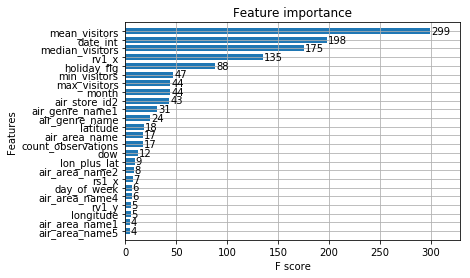

In [25]:
xgboost.plot_importance(model, max_num_features=28, height=0.7)

In [22]:
test['visitors'] = xgb_test_pred_df.values
sub = test[['id','visitors']].copy()
sub.to_csv('submission_rs_recruit_v11_xgbm_v13_v02.csv', index=False)
print('Done')

Done
